In [1]:
%load_ext watermark

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic
from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES_AGG = [
    "farleft_agg",
    "left_agg",
    "green_agg",
    "center_agg",
    "right_agg",
    "farright_agg",
]
SPAN = 25
ALPHA = 2 / (SPAN + 1)

In [2]:
az.style.use("arviz-darkgrid")


def stdz(series: pd.Series) -> pd.Series:
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()

Let's load the data and transform every missing values to 0: except for the "other" category, when a party is missing, this means that it got 0 votes, so it makes sense to replace NaNs by 0s. Note however that these zeros do not come from the multinomial process - unlike the zeros in the "other" category, but from an earlier process that determines if any given party competes in the election. We'll deal with that below, but let's already remark that this looks a lot like a zero-inflated process...

In [3]:
d = pd.read_excel("../data/results_by_districts_paris.xlsx", index_col=0)
# a party that wasn't there won 0 ballots:
d[PARTIES] = d[PARTIES].fillna(0).astype(int)

# keep track of which party was the incumbent for each election:
INCUMBENTS = {
    date: incumbent
    for date, incumbent in zip(
        d.date.unique(),
        [
            "right",
            "right",
            "left",
            "left",
            "left",
            "right",
            "right",
            "left",
            "right",
            "left",
            "left",
            "left",
        ],
    )
}
for date, incumbent in INCUMBENTS.items():
    d.loc[d.date == date, "incumbent"] = incumbent
right_inc = pd.Categorical(d.incumbent).codes
left_inc = 1 - right_inc

In [4]:
# account for temporal uncertainty by exponential decay of information brought by old elections:
#d["N"] = d[PARTIES].div(50).round().sum(1)
#d[PARTIES] = d[PARTIES].div(50).round()

TIMELINE = sorted(np.arange(np.min(d.date.dt.year.unique()), 2019), reverse=True)
year_weights = pd.DataFrame(index=TIMELINE, data=[(1 - ALPHA) ** i for i, _ in enumerate(TIMELINE)], columns=["year_weights"])

# add year_weights to results dataframe:
d.index = d.date.dt.year
d.index.name = "year"
d = d.join(year_weights).sort_values(["arrondissement", "date"]).reset_index(drop=True)

d["N"] = d[PARTIES].multiply(d.year_weights, axis="index").round().sum(1).astype(int)
d[PARTIES] = d[PARTIES].multiply(d.year_weights, axis="index").round().astype(int)
d

date  ville  arrondissement      N  farleft   left  green  center  \
0   2007-04-22  Paris               1   3793       99   1049     85     850   
1   2007-06-10  Paris               1   2830      101      0    816     339   
2   2008-03-09  Paris               1   2751       34   1028    197     238   
3   2009-06-07  Paris               1   2537      134    324    726     204   
4   2010-03-14  Paris               1   2553      155    568    547      93   
..         ...    ...             ...    ...      ...    ...    ...     ...   
235 2014-03-23  Paris              20  39907     4133  14885   4349       0   
236 2014-05-25  Paris              20  35630     3611   7678   6896    3062   
237 2015-12-06  Paris              20  38642     4798  14405   5779       0   
238 2017-04-23  Paris              20  82684    26319  11510      0   25291   
239 2017-06-11  Paris              20  52998    10658   9877   7169    6005   

     right  farright  other         type incumbent  year_weights  
0     1490       173     47    president     right      0.414588  
1     1422        66     86  legislative     right      0.414588  
2     1186        68      0   municipale      left      0.449137  
3      880        62    207     european      left      0.486565  
4      927       138    125     regional      left      0.527112  
..     ...       ...    ...          ...       ...           ...  
235   8325      2985   5230   municipale      left      0.726025  
236   4352      3328   6703     european     right      0.726025  
237   6560      3915   3185     regional      left      0.786527  
238  10570      4897   4097    president      left      0.923077  
239   3969      2258  13062  legislative      left      0.923077  

[240 rows x 14 columns]

What's the proportion of zeros in the respective categories?

In [115]:
1 - d[PARTIES].astype(bool).mean(axis=0).round(2)

farleft     0.02
left        0.02
green       0.08
center      0.17
right       0.00
farright    0.00
other       0.02
dtype: float64

Note that zeros in the category "other" are real multinomial zeros, while zeros in farleft, green and center result from the absence of these categories in the multinomial - they were eliminated upstream from the multinomial trials and are therefore not real multinomial zeros. Also note that the zero-inflated categories are not "jointly-inflated" (green is not necessaricly 0 when center is, and vice-versa).

Now let's look at each category's distribution (we zoom-in to really see zero-inflations):

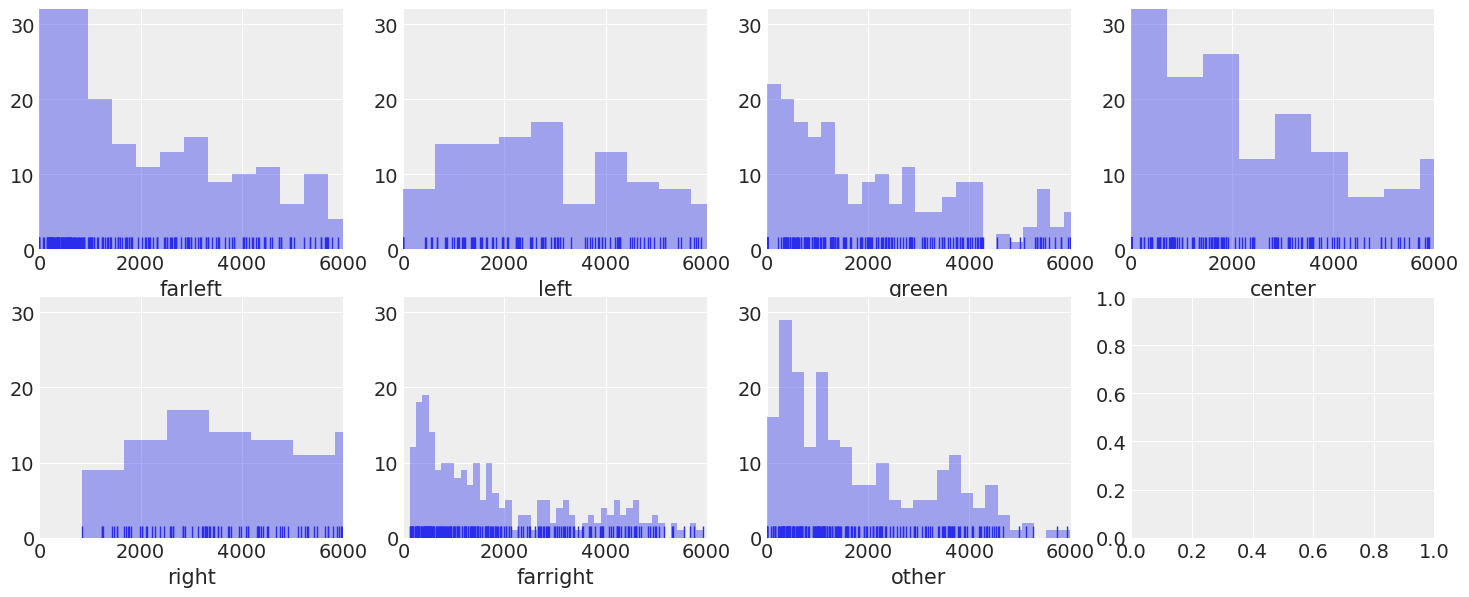

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(18, 7))
i = 0
for line in axes:
    for col in line:
        try:
            sns.distplot(d[PARTIES[i]], bins=60, kde=False, rug=True, ax=col)
            col.set_xlim([0, 6_000])
            col.set_ylim([0, 32])
            i += 1
        except IndexError:
            continue

That's not the best plot, but we can see that farleft, green and center do have a tendency to zero-inflation. The zero inflation comes from the fact that sometimes, some parties don't compete in a given election. Here, this process is simulated exactly like it happened in reality for the four elections in our dataset - thanks to the variable `parties_available`. So, during the four elections, some parties are not available in all or some districts. Now, how can we model this mixed process?

First, let's define index variables:

In [5]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)

type_id, types = d.type.factorize(sort=True)
Ntypes = len(types)

Nparties = len(PARTIES) - 1
N = d.N.values
R_obs = d[PARTIES].values

# which parties are available for choice
# huge value for missing parties, so that probability is 0 after softmax:
parties_available = d[PARTIES].astype(bool).astype(int).iloc[:, :-1].replace(to_replace=0, value=50_000).values
parties_available

array([[    1,     1,     1,     1,     1,     1],
       [    1, 50000,     1,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1],
       ...,
       [    1,     1,     1, 50000,     1,     1],
       [    1,     1, 50000,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1]])

Then we add a predictor to the dataset, which is the unemployment rate in Paris on a quarterly basis:

In [6]:
unemp = pd.read_excel(
    "../data/predictors/chomage-zone-demploi-2003-2019.xls",
    header=5,
    sheet_name="txcho_ze",
)
unemp = unemp[unemp["LIBZE2010"] == "Paris"].iloc[:, 4:].T
unemp.columns = ["unemployment"]

# as timestamps variables:
unemp.index = pd.PeriodIndex(start=unemp.index[0], periods=len(unemp), freq="Q")
unemp

unemployment
2003Q1           8.4
2003Q2           8.7
2003Q3           8.6
2003Q4           9.0
2004Q1           9.2
...              ...
2018Q2           7.8
2018Q3           7.8
2018Q4           7.5
2019Q1           7.4
2019Q2           7.2

[66 rows x 1 columns]

Now ne need to import the poll aggregation for each election. This will be our baseline for each party in each district:

In [7]:
train_polls = pd.read_excel(
    "../data/polls_1st_round/aggregated_polls.xlsx", index_col=0
)

test_polls = pd.read_excel(
    "/Users/alex_andorra/repos/contesdefaits/modeles/euro/agg_polls_euro2019.xlsx"
).iloc[-1]
test_polls = test_polls.drop(["souv", "other"])
test_polls.index = train_polls.columns[1:]
test_polls["type"] = "europeennes"

aggregated_polls = train_polls.append(test_polls, ignore_index=True)
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].div(100)
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513         0.03      0.24   
1   legislatives   2007-06-10             916         0.07      0.28   
2     municipale   2008-03-09             755         0.04      0.45   
3    europeennes   2009-06-07            2287         0.13      0.20   
4     regionales   2010-03-14             907         0.10      0.29   
5      president   2012-04-22            1400         0.14      0.28   
6   legislatives   2012-06-10            1193         0.08      0.32   
7     municipale   2014-03-23             977         0.06      0.38   
8    europeennes   2014-05-25            3248         0.08      0.17   
9     regionales   2015-12-06            1749         0.05      0.23   
10     president   2017-04-23            1555         0.19      0.08   
11  legislatives   2017-06-11            1299         0.12      0.08   
12   europeennes   2019-05-25            2221         0.08      0.05   

    green_agg  center_agg  right_agg  farright_agg  
0        0.01        0.19       0.27          0.14  
1        0.04        0.11       0.41          0.06  
2        0.06        0.08       0.33          0.02  
3        0.13        0.11       0.27          0.06  
4        0.14        0.05       0.29          0.09  
5        0.03        0.10       0.27          0.16  
6        0.05        0.03       0.34          0.15  
7        0.07        0.00       0.37          0.08  
8        0.09        0.10       0.21          0.23  
9        0.06        0.00       0.28          0.29  
10       0.00        0.24       0.19          0.22  
11       0.03        0.30       0.21          0.17  
12       0.08        0.23       0.14          0.25

As you probably noticed, the polls are in shares of support. Since our link function is softmax, we need to convert these proportions back on the real line (because the polls will be used before the link function appears in our model). It's [really easy to invert the softmax](https://math.stackexchange.com/questions/2786600/invert-the-softmax-function): we just have to take the log of each proportion and add an arbitrary constant -- here, we chose 1.

But hold on! There are two zeros in these data (for center party during the 2014 city-council and 2015 regional elections). It's due to the fact that this party was not running during these elections. When we'll take the logarithm of these zeros, we'll get minus infinity -- spoiler alert: our sampler won't like that. So we'll have to use a trick here.

Notice that the green party has a very low share of polls in the 2017 presidential elections. It's because there were some polls featuring the green party at the beginning of the race, but not anymore once the party dropped out. This is useful for us here: as a results, the poll aggregation is very near zero but not _exactly_ zero, so on the log scale it will give a very negative number but not minus infinity.

So here is our trick: let's replace the zeros for the center party by the value for the green party during the 2017 presidential election. This might seem like a cheap trick but it actually makes some conceptual sense: our model is concerned with the _latent_ support of each party's in the population. And in reality, neither the center nor the green parties were at _exactly_ zero percent support during these years -- they just had a very low support, which actually forced them to drop out and make alliances. So, replacing our perfect zeros with not-so-perfect zeros does make sense!

Here is how it looks in code:

In [8]:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].replace(
    to_replace=0, value=aggregated_polls.loc[aggregated_polls.dateelection == "2017-04-23", "green_agg"].values[0]
)

# revert the softmax:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].apply(np.log) + 1

# standardize:
# aggregated_polls[PARTIES_AGG] = stdz(aggregated_polls[PARTIES_AGG])
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513        -2.63     -0.43   
1   legislatives   2007-06-10             916        -1.61     -0.29   
2     municipale   2008-03-09             755        -2.33      0.19   
3    europeennes   2009-06-07            2287        -1.04     -0.63   
4     regionales   2010-03-14             907        -1.32     -0.24   
5      president   2012-04-22            1400        -0.99     -0.29   
6   legislatives   2012-06-10            1193        -1.53     -0.14   
7     municipale   2014-03-23             977        -1.88      0.04   
8    europeennes   2014-05-25            3248        -1.58     -0.79   
9     regionales   2015-12-06            1749        -1.94     -0.47   
10     president   2017-04-23            1555        -0.67     -1.57   
11  legislatives   2017-06-11            1299        -1.14     -1.53   
12   europeennes   2019-05-25            2221        -1.48     -1.98   

    green_agg  center_agg  right_agg  farright_agg  
0       -3.95       -0.67      -0.30         -0.95  
1       -2.30       -1.20       0.12         -1.76  
2       -1.85       -1.51      -0.12         -2.82  
3       -1.01       -1.19      -0.30         -1.85  
4       -1.00       -2.06      -0.24         -1.40  
5       -2.68       -1.27      -0.32         -0.84  
6       -1.98       -2.58      -0.09         -0.88  
7       -1.73      -22.24      -0.01         -1.50  
8       -1.42       -1.33      -0.54         -0.46  
9       -1.84      -22.24      -0.27         -0.24  
10     -22.24       -0.44      -0.64         -0.49  
11      -2.51       -0.19      -0.56         -0.75  
12      -1.49       -0.48      -0.95         -0.40

And now we combine all district- and city-level predictors as well as polls and election results into the same dataframe:

In [9]:
# add quarters to results dataframe:
d.index = pd.DatetimeIndex(d["date"].values).to_period("Q")
d.index.name = "quarter"
# merge with city-level unemployment:
d = d.join(unemp).sort_values(["arrondissement", "date"]).reset_index(drop=True)

# join polling aggregation:
d = d.merge(
    aggregated_polls.drop("type", 1),
    left_on="date",
    right_on="dateelection",
    how="left",
).drop("dateelection", 1)
d

date  ville  arrondissement      N  farleft   left  green  center  \
0   2007-04-22  Paris               1   3793       99   1049     85     850   
1   2007-06-10  Paris               1   2830      101      0    816     339   
2   2008-03-09  Paris               1   2751       34   1028    197     238   
3   2009-06-07  Paris               1   2537      134    324    726     204   
4   2010-03-14  Paris               1   2553      155    568    547      93   
..         ...    ...             ...    ...      ...    ...    ...     ...   
235 2014-03-23  Paris              20  39907     4133  14885   4349       0   
236 2014-05-25  Paris              20  35630     3611   7678   6896    3062   
237 2015-12-06  Paris              20  38642     4798  14405   5779       0   
238 2017-04-23  Paris              20  82684    26319  11510      0   25291   
239 2017-06-11  Paris              20  52998    10658   9877   7169    6005   

     right  farright  ...  incumbent year_weights unemployment  \
0     1490       173  ...      right     0.414588          7.8   
1     1422        66  ...      right     0.414588          7.8   
2     1186        68  ...       left     0.449137          6.6   
3      880        62  ...       left     0.486565          7.9   
4      927       138  ...       left     0.527112          8.2   
..     ...       ...  ...        ...          ...          ...   
235   8325      2985  ...       left     0.726025          8.7   
236   4352      3328  ...      right     0.726025          8.8   
237   6560      3915  ...       left     0.786527          8.7   
238  10570      4897  ...       left     0.923077          8.0   
239   3969      2258  ...       left     0.923077          8.0   

     samplesize_agg  farleft_agg  left_agg  green_agg  center_agg  right_agg  \
0              1513    -2.633513 -0.432471  -3.950292   -0.670963  -0.296018   
1               916    -1.613136 -0.288538  -2.295177   -1.196553   0.116238   
2               755    -2.327655  0.190572  -1.849138   -1.513482  -0.116553   
3              2287    -1.040641 -0.628886  -1.013539   -1.192074  -0.299655   
4               907    -1.319981 -0.240301  -0.996263   -2.061018  -0.240266   
..              ...          ...       ...        ...         ...        ...   
235             977    -1.884055  0.037657  -1.727255  -22.243938  -0.005215   
236            3248    -1.582788 -0.790411  -1.420928   -1.334419  -0.537229   
237            1749    -1.943570 -0.473766  -1.836909  -22.243938  -0.268955   
238            1555    -0.667318 -1.565596 -22.243938   -0.437694  -0.640817   
239            1299    -1.144984 -1.528224  -2.510045   -0.191539  -0.560378   

     farright_agg  
0       -0.946153  
1       -1.763649  
2       -2.824834  
3       -1.854871  
4       -1.398709  
..            ...  
235     -1.496337  
236     -0.460404  
237     -0.241968  
238     -0.493163  
239     -0.747776  

[240 rows x 22 columns]

Ok, everything's ready, let's run our model! This a varying-effects model that takes into account not only the variation in slopes and intercepts, but also accounts for the *covariation between slopes and intercepts* -- it exploits additional information about the population in order to shrink in both dimensions.

In [ ]:
# euro2019 (meas err on results, more elections?, pop_parties?)
# + Slack 
# + rethinking Carnet --> State-space Model / HMM (manages to add time-awareness and uncertainty?)

In [12]:
with pm.Model() as m_dos_effects:
    mus_parties = []
    log_unemployment = stdz(np.log(d.unemployment)).values
    for p_id, p in enumerate(PARTIES_AGG):
        stdz_polls = stdz(d[p]).values
        
        if p in ["left_agg", "right_agg"]:
            sd_dist = pm.Exponential.dist(1.0)
            packed_chol = pm.LKJCholeskyCov(f"pchol_district_p{p_id}", eta=4, n=4, sd_dist=sd_dist)

            # compute covariance matrix:
            chol = pm.expand_packed_triangular(n=4, packed=packed_chol, lower=True)
            cov = pm.math.dot(chol, chol.T)

            # extract rho and standard deviations:
            sigma_district = pm.Deterministic(f"sigma_district_p{p_id}", tt.sqrt(tt.diag(cov)))
            corr = tt.diag(sigma_district ** -1).dot(cov.dot(tt.diag(sigma_district ** -1)))
            r = pm.Deterministic(f"Rho_district_p{p_id}", corr[np.triu_indices(n=4, k=1)])

            # average itc and slopes:
            β = pm.Normal(
                f"β_p{p_id}",
                mu=np.array([-1.4, 0.0, 0.1, 0.0]),
                sd=np.array([0.5, 0.05, 0.05, 0.5]),
                shape=4,
            )
            
            # population of varying effects:
            β_district = pm.MvNormal(
                f"β_district_p{p_id}", mu=β, chol=chol, shape=(Ndistricts, 4)
            )
            type_effect = pm.Normal(
                f"type_effect_p{p_id}", mu=0., sigma=0.05, shape=Ntypes
            )
            
            if p == "right_agg":
                # linear model:
                mus_parties.append(
                    β_district[district_id, 0] + type_effect[type_id]
                    + β_district[district_id, 1] * log_unemployment
                    + β_district[district_id, 2] * stdz_polls
                    + β_district[district_id, 3] * right_inc
                )
            else:
                mus_parties.append(
                    β_district[district_id, 0] + type_effect[type_id]
                    + β_district[district_id, 1] * log_unemployment
                    + β_district[district_id, 2] * stdz_polls
                    + β_district[district_id, 3] * left_inc
                )

        else:
            sd_dist = pm.Exponential.dist(1.0)
            packed_chol = pm.LKJCholeskyCov(f"pchol_district_p{p_id}", eta=4, n=3, sd_dist=sd_dist)
            chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
            cov = pm.math.dot(chol, chol.T)
            sigma_district = pm.Deterministic(f"sigma_district_p{p_id}", tt.sqrt(tt.diag(cov)))
            corr = tt.diag(sigma_district ** -1).dot(cov.dot(tt.diag(sigma_district ** -1)))
            r = pm.Deterministic(f"Rho_district_p{p_id}", corr[np.triu_indices(n=3, k=1)])
            
            if p == "center_agg":
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-1.4, 0.0, 0.1]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            elif p in ["farleft_agg", "green_agg"]:
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-1.9, 0.0, 0.1]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            elif p == "farright_agg":
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-2.7, 0.0, 0.0]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            β_district = pm.MvNormal(
                f"β_district_p{p_id}", mu=β, chol=chol, shape=(Ndistricts, 3)
            )
            type_effect = pm.Normal(
                f"type_effect_p{p_id}", mu=0., sigma=0.05, shape=Ntypes
            )
            mus_parties.append(
                β_district[district_id, 0] + type_effect[type_id]
                + β_district[district_id, 1] * log_unemployment
                + β_district[district_id, 2] * stdz_polls
            )

    mus_parties = tt.as_tensor_variable(mus_parties).T
    mus_parties = pm.Normal("mus_parties", mus_parties, 0.1, shape=mus_parties.tag.test_value.shape)
    # zero-inflation process:
    # push non-available parties towards -inf:
    mus_parties = parties_available * mus_parties
    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-3.0))
    #vary_pivot = pm.Normal("vary_pivot", mu=-3., sigma=0.065, shape=(Ndistricts, 1))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for all elections:
    p_district = pm.Deterministic("p_district", tt.nnet.softmax(mus_parties))

    R = pm.Multinomial("R", n=N, p=p_district, observed=R_obs)
    #prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

In [13]:
with m_dos_effects:
    trace_dos_effects = pm.sample(
        1000, tune=2000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
NUTS: [mus_parties, type_effect_p5, β_district_p5, β_p5, pchol_district_p5, type_effect_p4, β_district_p4, β_p4, pchol_district_p4, type_effect_p3, β_district_p3, β_p3, pchol_district_p3, type_effect_p2, β_district_p2, β_p2, pchol_district_p2, type_effect_p1, β_district_p1, β_p1, pchol_district_p1, type_effect_p0, β_district_p0, β_p0, pchol_district_p0]


There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [14]:
az.summary(trace_dos_effects, round_to=2)

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
β_p0[0]            -2.57  0.23   -3.02    -2.17        0.0      0.0   2479.57   
β_p0[1]            -0.11  0.05   -0.20    -0.01        0.0      0.0   2163.01   
β_p0[2]             0.27  0.03    0.20     0.33        0.0      0.0   2419.24   
β_district_p0[0,0] -3.02  0.05   -3.12    -2.92        0.0      0.0   2012.01   
β_district_p0[0,1] -0.40  0.06   -0.50    -0.29        0.0      0.0   2324.32   
...                  ...   ...     ...      ...        ...      ...       ...   
p_district[239,2]   0.14  0.00    0.13     0.14        0.0      0.0   1820.45   
p_district[239,3]   0.12  0.00    0.11     0.12        0.0      0.0   1887.53   
p_district[239,4]   0.08  0.00    0.07     0.08        0.0      0.0   1636.78   
p_district[239,5]   0.04  0.00    0.04     0.05        0.0      0.0   1916.48   
p_district[239,6]   0.24  0.00    0.24     0.24        0.0      0.0   3863.10   

                     ess_sd  ess_bulk  ess_tail  r_hat  
β_p0[0]             2479.57   2535.76   1578.00    1.0  
β_p0[1]             2163.01   2193.92   1870.62    1.0  
β_p0[2]             2419.24   2506.26   1743.31    1.0  
β_district_p0[0,0]  2008.96   2008.41   1773.21    1.0  
β_district_p0[0,1]  2283.17   2337.98   1800.67    1.0  
...                     ...       ...       ...    ...  
p_district[239,2]   1820.45   1854.36    744.79    1.0  
p_district[239,3]   1886.11   1881.36   1405.47    1.0  
p_district[239,4]   1636.78   1638.43   1198.87    1.0  
p_district[239,5]   1914.34   1915.30   1112.50    1.0  
p_district[239,6]   3863.10   3871.22   1269.42    1.0  

[3658 rows x 11 columns]

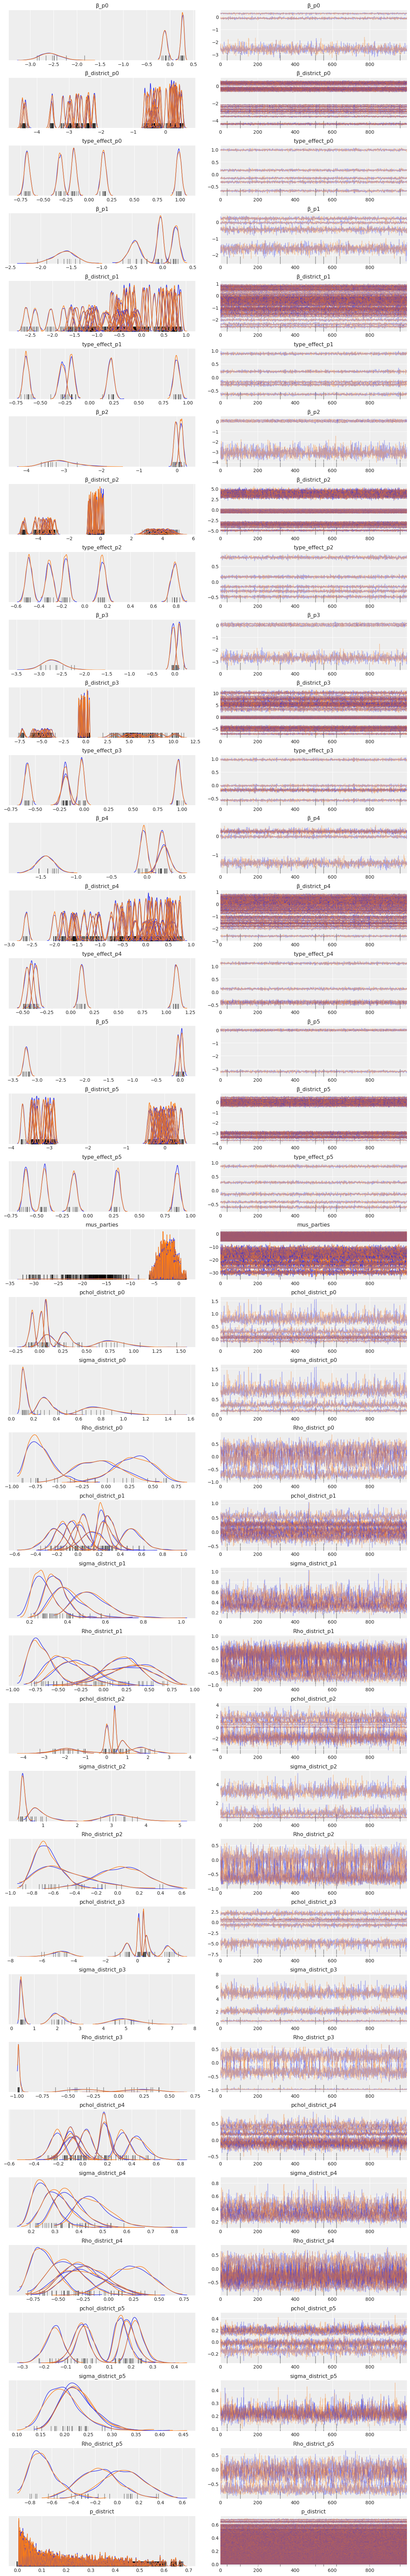

In [15]:
az.plot_trace(trace_dos_effects, compact=True);

In [16]:
share_est = trace_dos_effects["p_district"]
share_mean = share_est.mean(0)

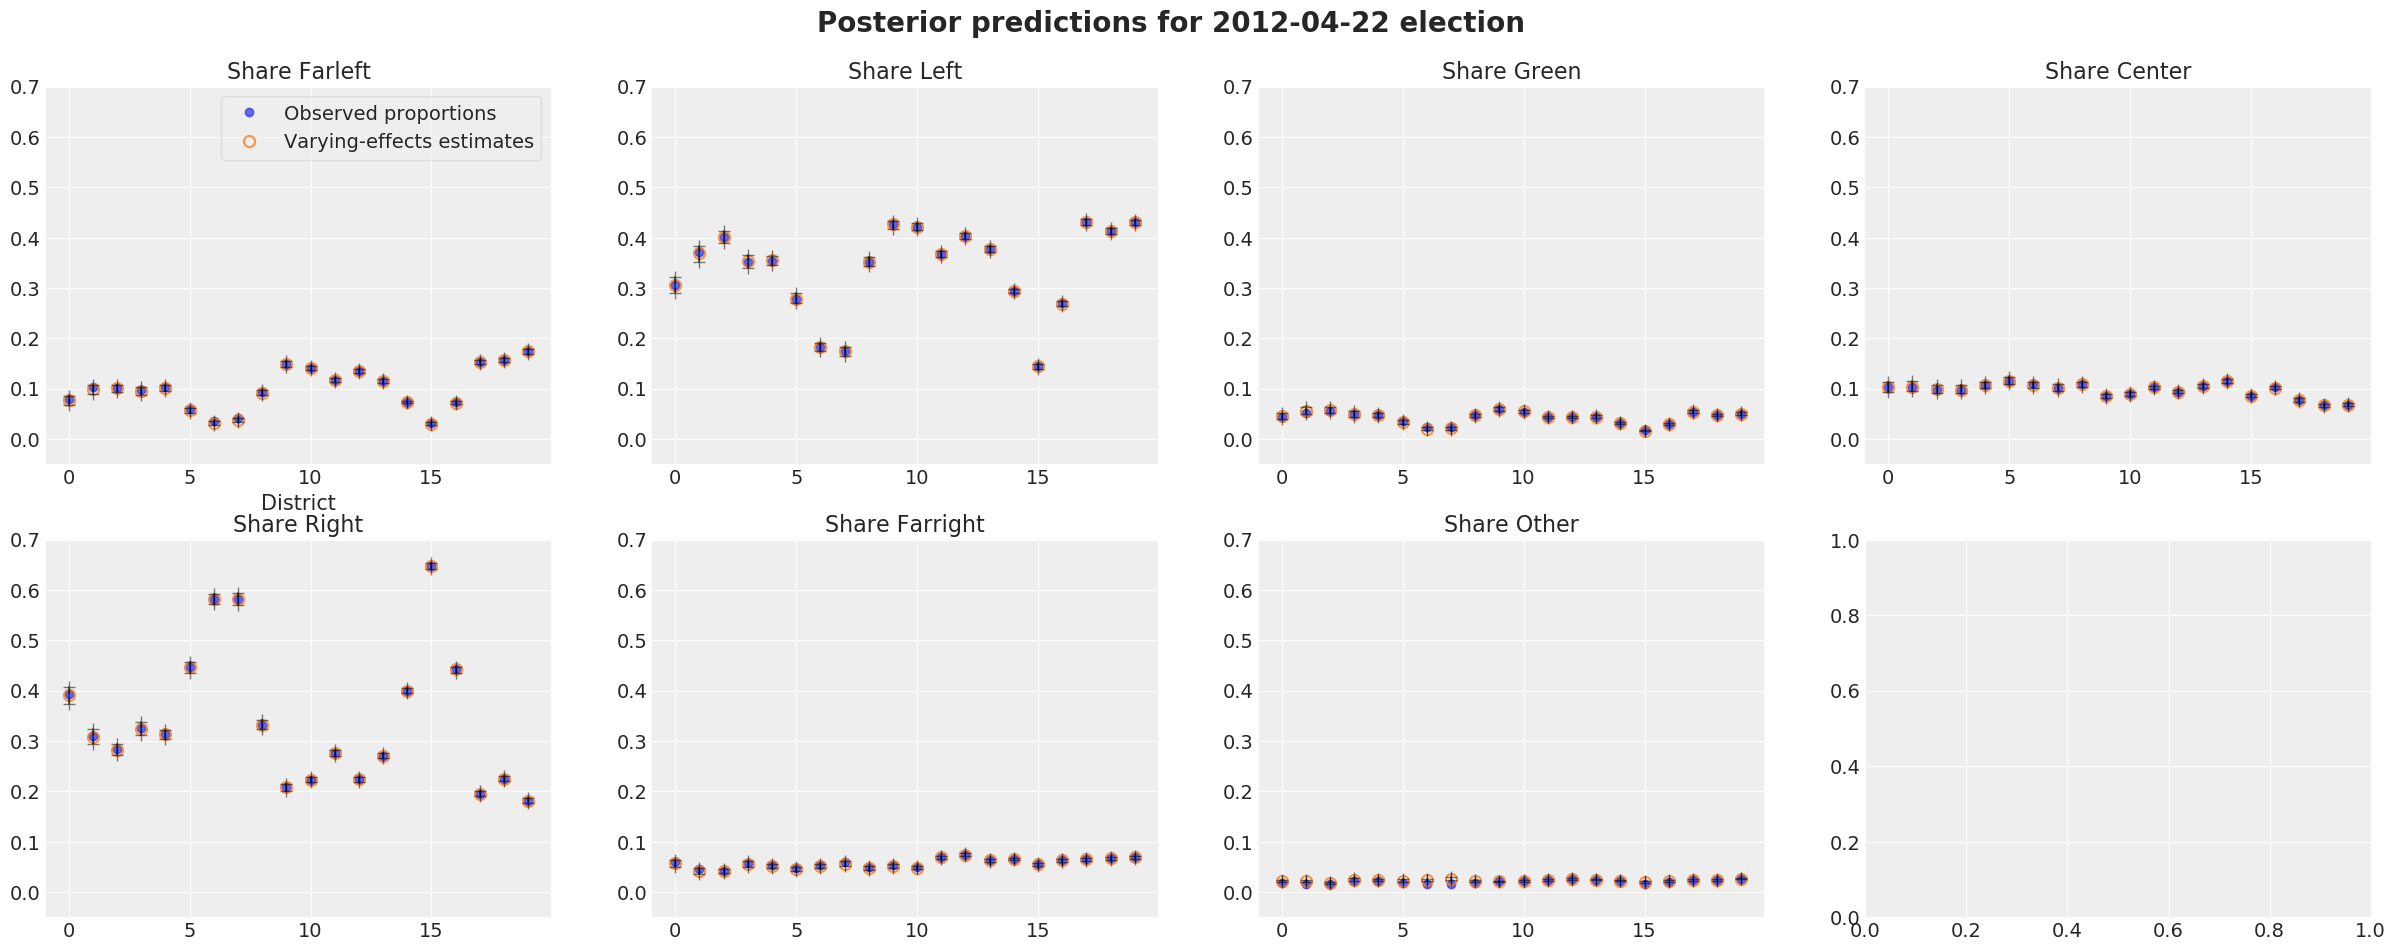

In [26]:
election = np.random.choice(d.date.unique(), replace=False)
election_mask = d.date == election
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            np.arange(Ndistricts),
            d.loc[election_mask, PARTIES[i]] / d.loc[election_mask, "N"],
            "o",
            ms=6,
            alpha=0.7,
            label="Observed proportions",
        )
        ax.plot(
            np.arange(Ndistricts),
            share_mean[election_mask, i],
            "o",
            fillstyle="none",
            ms=8,
            markeredgewidth=1.5,
            alpha=0.8,
            label="Varying-effects estimates",
        )
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, election_mask, i], credible_interval=0.99).T,
            "k-+",
            ms=8,
            alpha=0.5,
        )
        ax.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
        ax.set_title(f"Share {PARTIES[i].title()}")
        ax.set_ylim([-0.05, 0.7])
        if i == 0:
            ax.set_xlabel("District")
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    f"Posterior predictions for {np.datetime_as_string(election, unit='D')} election",
    y=0.95,
    size=20,
    weight="bold",
);

In [188]:
with open("trace_dos_effects.pkl", "wb") as f:
    pickle.dump(
        {"model": m_dos_effects, "trace": trace_dos_effects}, f
    )

In [111]:
with open("trace_dos_effects.pkl", "rb") as f:
    data = pickle.load(f)
m_dos_effects, trace_dos_effects = data["model"], data["trace"]

In [27]:
test_unemployment = ((np.log(unemp["2019Q2"]) - np.log(d["unemployment"]).mean()) / np.log(d["unemployment"]).std()).iloc[0, 0]
post_preds = []

for p_id, p in enumerate(PARTIES_AGG):
    test_polls = aggregated_polls.loc[aggregated_polls.dateelection == "2019-05-25", p].values[0]
    test_polls = (test_polls - d[p].mean()) / d[p].std()
    
    post_preds.append(
        trace_dos_effects[f"β_district_p{p_id}"][:, :, 0]
        + trace_dos_effects[f"type_effect_p{p_id}"][:, 0, None]
        + trace_dos_effects[f"β_district_p{p_id}"][:, :, 1] * test_unemployment
        + trace_dos_effects[f"β_district_p{p_id}"][:, :, 2] * test_polls
    )
post_preds = np.asarray(post_preds).T
post_preds.shape

(20, 2000, 6)

In [29]:
vary_pivot = np.full(shape=(Ndistricts, 2000, 1), fill_value=-3.0)
#vary_pivot = trace_dos_effects["vary_pivot"].transpose([1, 0, 2])
post_preds = np.c_[post_preds, vary_pivot]
post_preds.shape

(20, 2000, 7)

In [30]:
share_est = softmax(post_preds, axis=2)
share_mean = share_est.mean(1)
share_est.shape

(20, 2000, 7)

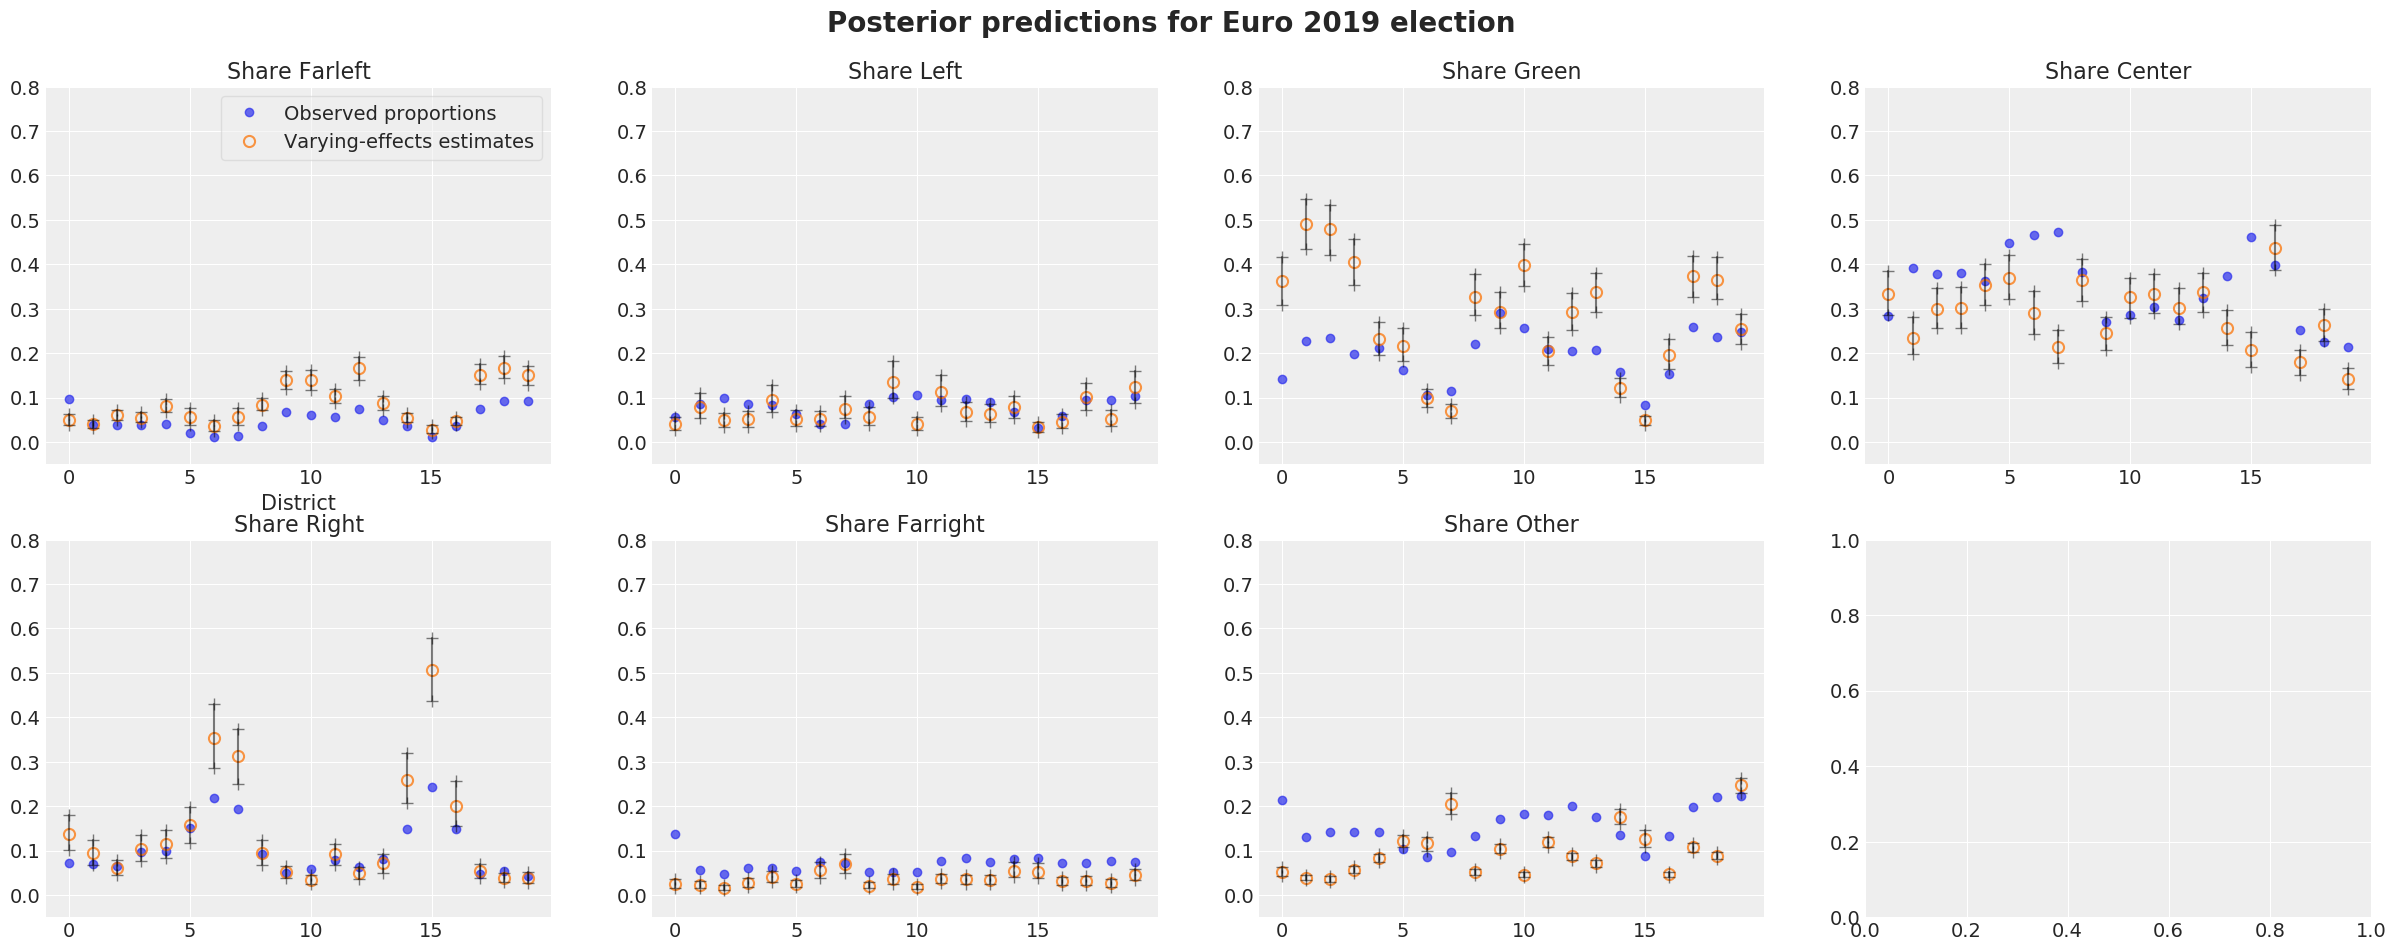

In [31]:
euro2019 = pd.read_excel("../data/raw_election_results_1st_round/euro2019-districts.xlsx", index_col=0)
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            np.arange(Ndistricts),
            euro2019[PARTIES[i]] / euro2019["N"],
            "o",
            ms=6,
            alpha=0.7,
            label="Observed proportions",
        )
        ax.plot(
            np.arange(Ndistricts),
            share_mean[:, i],
            "o",
            fillstyle="none",
            ms=8,
            markeredgewidth=1.5,
            alpha=0.8,
            label="Varying-effects estimates",
        )
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, :, i].T, credible_interval=0.99).T,
            "k-+",
            ms=8,
            alpha=0.5,
        )
        ax.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
        ax.set_title(f"Share {PARTIES[i].title()}")
        ax.set_ylim([-0.05, 0.8])
        if i == 0:
            ax.set_xlabel("District")
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    "Posterior predictions for Euro 2019 election",
    y=0.95,
    size=20,
    weight="bold",
);